In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from sklearn.datasets import make_regression, make_classification
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tqdm
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ML/DL with Torch

For the whole tutorial, we will reuse the same "pipeline":
* Meet the Data
* Identify the task
* Choose a Model
* Choose a Loss
* Train
* Iterate until you have some results.

## MLP

A Multi-Layer Perceptron is basically a stack of fully-connected layers ```nn.Linear``` with non-linearities in between.

These non-linearities are the reason MLP work "so well".
I would suggest you use the Leaky ReLU activation for your networks, unless you need a sigmoid-like activation.

In [39]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP,self).__init__()
    self.layer1 = nn.Linear(28*28*1, 256)
    self.layer2 = nn.Linear(256, 128)
    self.layer3 = nn.Linear(128,10)
  
  def forward(self,x):
    x = torch.nn.Flatten()(x) 
    x = F.leaky_relu(self.layer1(x)) 
    x = F.leaky_relu(self.layer2(x)) 
    x = self.layer3(x)
    return x

In [40]:
train_ds = torchvision.datasets.MNIST(".", train=True, download=True, 
                                      transform=torchvision.transforms.ToTensor())
# we use ToTensor since the default output of the MNIST object is PIL images.

batch_size = 128
validation_split = 0.1
shuffle_dataset = True
random_seed = None
# Creating data indices for training and validation splits:
dataset_size = len(train_ds)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Make the datset ready to be loaded for training !

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, sampler=train_sampler
)
validation_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, sampler=valid_sampler
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        ".",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=batch_size,
    shuffle=True,
)

#### Meet the Data

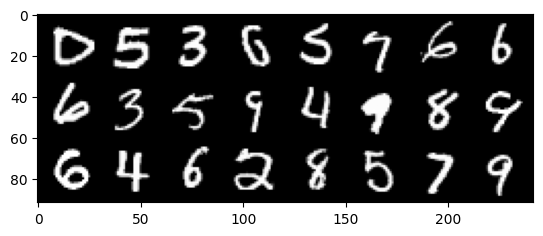

  0  5  3  6  5  7  6  6  6  3  5  9  4  9  8  9  6  4  6  2  8  5  7  9


In [41]:
def imshow(img):
    img = img # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)
images = images[:3*8]
imshow(torchvision.utils.make_grid(images))
plt.show()
print(''.join('%3s'%int(labels.numpy()[j]) for j in range(3*8)))

#### Training

I would suggest you use the Adam optimizer. It is one of the most used optimizers available, and for good reasons. Its performance is in general better than the SGD, even with enhancements like momentum.

Note the use of the ```to()``` method. Since I have a GPU, I might as well use it.

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader) * batch_size
n_val = len(validation_loader) * batch_size
N_EPOCHS = 10
for _ in range(N_EPOCHS):
    total_loss = 0
    total_acc = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += torch.sum(torch.max(output, dim=1)[1] == labels).item() * 1.0
    # validation

    total_loss_val = 0
    total_acc_val = 0
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        loss = criterion(output, labels)

        total_loss_val += loss.item()
        total_acc_val += torch.sum(torch.max(output, dim=1)[1] == labels).item() * 1.0
    train_errors.append(total_loss / n_train)
    train_acc.append(total_acc / n_train)
    val_errors.append(total_loss_val / n_val)
    val_acc.append(total_acc_val / n_val)

print("Training complete")


Training complete


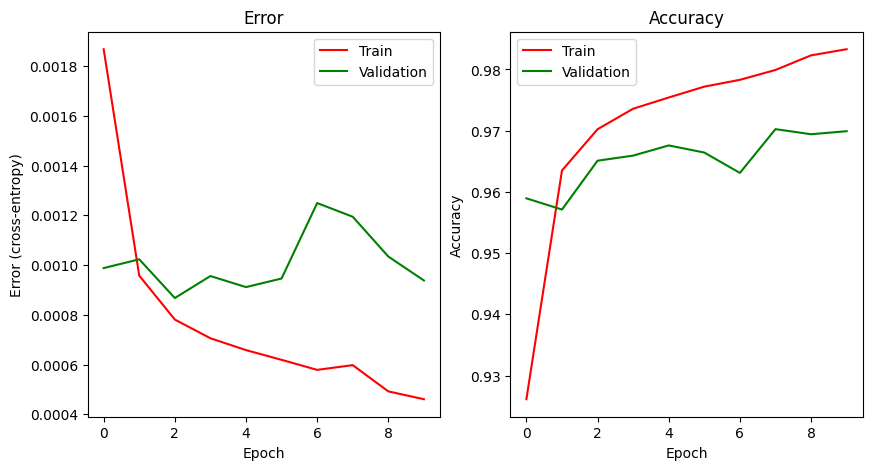

Test accuracy : 97.13%


In [43]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(train_errors, "r", label="Train")
ax[0].plot(val_errors, "g", label="Validation")
ax[0].set_title("Error")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, "r", label="Train")
ax[1].plot(val_acc, "g", label="Validation")
ax[1].set_title("Accuracy")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    total_acc += torch.sum(torch.max(output, dim=1)[1] == labels).item() * 1.0

print(f"Test accuracy : {100*total_acc / len(test_loader.dataset)}%")

## ConvNet

In [77]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 maxpool
        self.fc1 = nn.Linear(4 * 4 * 10, 100)
        self.fc2 = nn.LazyLinear(10) # No Need to find the input format! But under-development...

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))  # 24x24x10
        x = self.pool(x)  # 12x12x10
        x = F.leaky_relu(self.conv2(x))  # 8x8x10
        x = self.pool(x)  # 4x4x10
        x = torch.nn.Flatten()(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x) # No activation function here.
        return x

In [78]:
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader) * batch_size
n_val = len(validation_loader) * batch_size
N_EPOCHS = 10
for _ in range(N_EPOCHS):
    total_loss = 0
    total_acc = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += torch.sum(torch.max(output, dim=1)[1] == labels).item() * 1.0
    # validation

    total_loss_val = 0
    total_acc_val = 0
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        loss = criterion(output, labels)

        total_loss_val += loss.item()
        total_acc_val += torch.sum(torch.max(output, dim=1)[1] == labels).item() * 1.0
    train_errors.append(total_loss / n_train)
    train_acc.append(total_acc / n_train)
    val_errors.append(total_loss_val / n_val)
    val_acc.append(total_acc_val / n_val)

print("Training complete")


/home/ubuntu/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Training complete


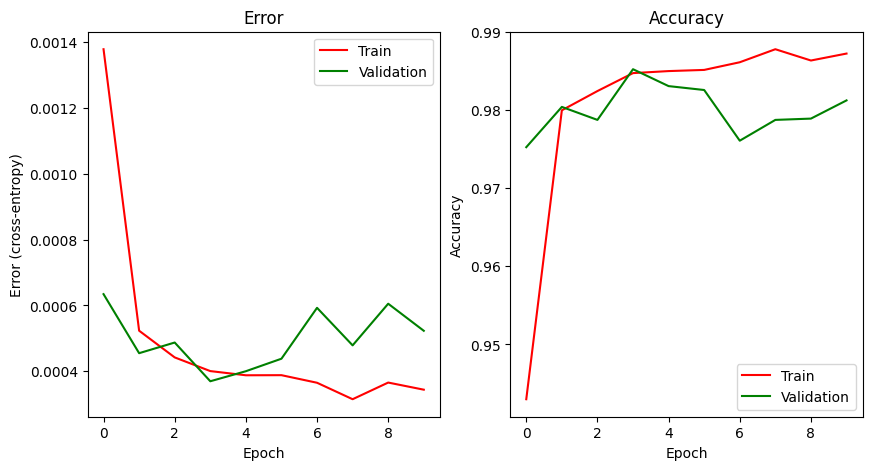

Test accuracy : 98.38%


In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(train_errors, "r", label="Train")
ax[0].plot(val_errors, "g", label="Validation")
ax[0].set_title("Error")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, "r", label="Train")
ax[1].plot(val_acc, "g", label="Validation")
ax[1].set_title("Accuracy")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    total_acc += torch.sum(torch.max(output, dim=1)[1] == labels).item() * 1.0

print(f"Test accuracy : {100*total_acc / len(test_loader.dataset)}%")

#### Inside a ConvNet

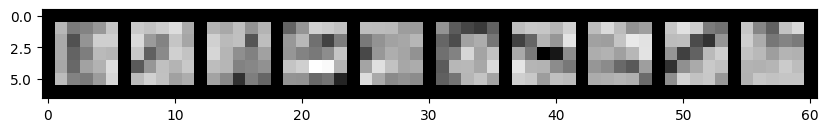

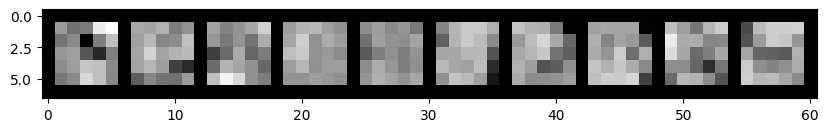

In [80]:
def visTensor(tensor, ch=0, allkernels=False, nrow=10, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)), vmin=-2, vmax=2)


layer = 1
filter1 = model.conv1.weight.cpu().data.clone()
filter2 = model.conv2.weight.cpu().data.clone()

visTensor(filter1, ch=0, allkernels=False)
visTensor(filter2, ch=0, allkernels=False)

plt.show()

Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
Linear(in_features=160, out_features=100, bias=True)
torch.Size([5, 100])
Linear(in_features=100, out_features=10, bias=True)
torch.Size([5, 10])


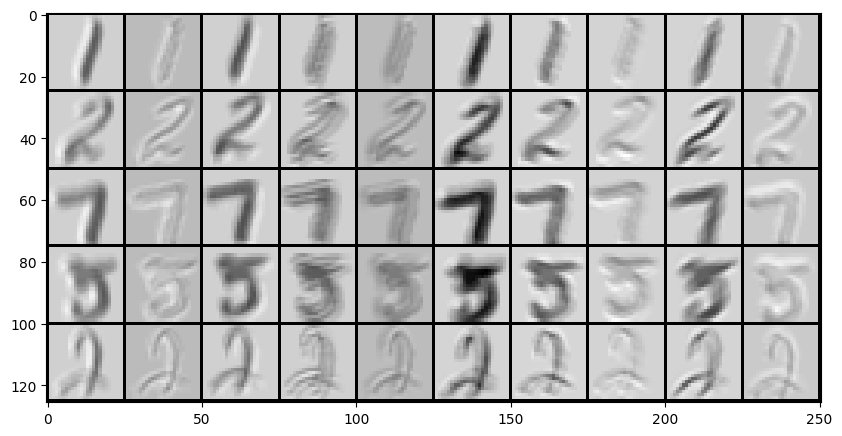

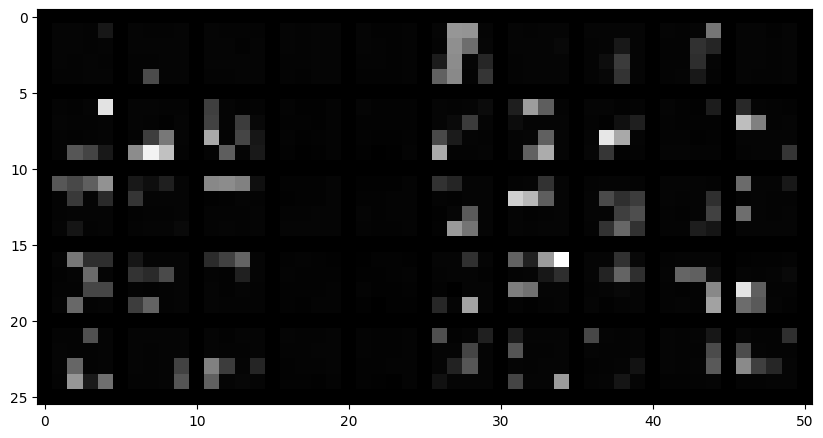

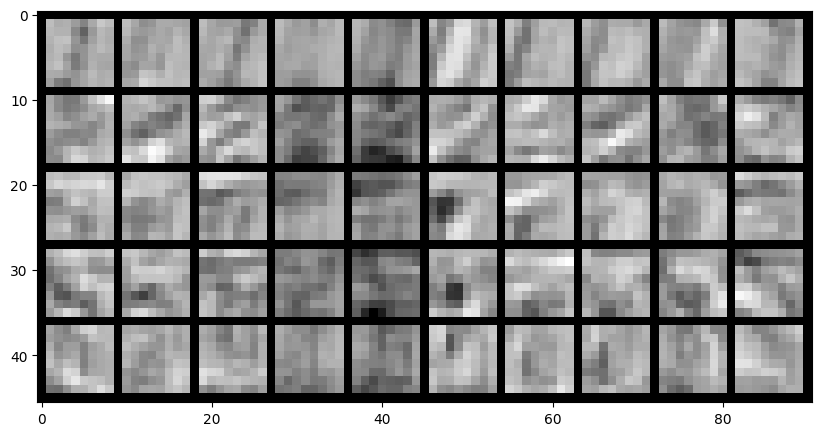

In [94]:
x =  images[:5]
visualisation = {}


def hook_fn(m, i, o):
    visualisation[m] = o


def get_all_layers(net):
    for name, layer in net._modules.items():
        # If it is a sequential, don't register a hook on it
        # but recursively register hook on all it's module children
        if isinstance(layer, nn.Sequential):
            get_all_layers(layer)
        else:
            # it's a non sequential. Register a hook
            layer.register_forward_hook(hook_fn)


get_all_layers(model)


out = model(x)

# Just to check whether we got all layers
visualisation.keys()  # output includes sequential layers

for key in visualisation.keys():
    print(key)
    value = visualisation.get(key)
    if isinstance(key, torch.nn.Linear):
        plt.figure()
        plt.imshow(value.cpu())
    else:
        visTensor(value.cpu(), ch=0, allkernels=True, nrow=10)


In [89]:
type(list(visualisation.keys())[-1])

torch.nn.modules.linear.Linear

## Common Architectures

### ResNet

### GAN

### RNN